In [1]:
#设置所有分类目录的名称
import os

base_dir = 'E:\python projects\cats_and_dogs'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [2]:
#得到数据集的大小
print(len(os.listdir(train_cats_dir)), len(os.listdir(train_dogs_dir)),len(os.listdir(validation_cats_dir)),len(os.listdir(validation_dogs_dir)))

1000 1000 500 500


In [4]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [9]:
#载入预训练好的模型权重文件，并用keras内预置的架构来构建模型
weights_file = 'E:\\python projects\\inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pretrain_model = InceptionV3(input_shape=(150,150,3), include_top=False, weights=None)
pretrain_model.load_weights(weights_file)

In [11]:
#将模型中的所有层均设置为不更新
for layer in pretrain_model.layers: 
    layer.trainable = False
    
#考虑到输出尺寸不可过小，取mixed7层的输出(7*7)作为卷积网络部分的最后输出，即全连接层的输入。
last_layer = pretrain_model.get_layer('mixed7') 
last_output = last_layer.output

In [14]:
#最后加上全连接层和分类层，编译。
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pretrain_model.input, x)
model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.0001), metrics=['acc'])

In [15]:
#查看网络结构
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_376 (Conv2D)             (None, 74, 74, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_376 (BatchN (None, 74, 74, 32)   96          conv2d_376[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 74, 74, 32)   0           batch_normalization_376[0][0]    
__________________________________________________________________________________________________
conv2d_377

In [16]:
#模型建完，开始准备数据。分别为训练集和测试集创建数据生成器，并设置生成器的参数，用于为模型连续生成标准化的数据。
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#实例化，设置的是对单张图片的操作属性（缩放、剪切、拉伸等）
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)
#用实例的方法构建生成器，设置的是生成流程的属性（目录、batch数、分类类别等）
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150,150), batch_size=20, class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(150,150), batch_size=20, class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [17]:
#用准备好的模型和生成器训练2轮，目的是更新一下全连接层和分类层的权重。
history = model.fit_generator(train_generator, 
                              steps_per_epoch=100, 
                              epochs=2, 
                              validation_data=validation_generator, 
                              validation_steps=50, 
                              verbose=2)

Epoch 1/2
 - 585s - loss: 0.5078 - acc: 0.7540 - val_loss: 0.7157 - val_acc: 0.8320
Epoch 2/2
 - 566s - loss: 0.3845 - acc: 0.8320 - val_loss: 0.2375 - val_acc: 0.9320


In [22]:
#卷积网络模型，越排在前面的层提取的越是泛化特征，越具有普适功能；越排在后面就越只提取针对性特征，只针对特殊分类或项目。所以应对最上层部分进行
#再训练，以获得更好的分类效果。比如对mixed6之后的所有层进行权重更新（反向传播），使用SGD进行优化。
from tensorflow.keras.optimizers import SGD

unfreeze = False
for layer in pretrain_model.layers:
    if unfreeze:
        layer.trainable = True
    if layer.name == 'mixed6':
        unfreeze = True

model.compile(loss='binary_crossentropy', optimizer=SGD(lr=0.00001, momentum=0.9), metrics=['acc'])       

In [23]:
history = model.fit_generator(train_generator, 
                              steps_per_epoch=100, 
                              epochs=50, 
                              validation_data=validation_generator, 
                              validation_steps=50, 
                              verbose=2)

Epoch 1/50
 - 611s - loss: 0.2903 - acc: 0.8775 - val_loss: 0.2525 - val_acc: 0.9340
Epoch 2/50
 - 605s - loss: 0.3008 - acc: 0.8665 - val_loss: 0.2576 - val_acc: 0.9350
Epoch 3/50
 - 652s - loss: 0.3055 - acc: 0.8635 - val_loss: 0.2628 - val_acc: 0.9350
Epoch 4/50
 - 694s - loss: 0.3002 - acc: 0.8720 - val_loss: 0.2639 - val_acc: 0.9350
Epoch 5/50
 - 670s - loss: 0.2954 - acc: 0.8650 - val_loss: 0.2680 - val_acc: 0.9330
Epoch 6/50
 - 669s - loss: 0.2836 - acc: 0.8800 - val_loss: 0.2666 - val_acc: 0.9350
Epoch 7/50
 - 686s - loss: 0.2674 - acc: 0.8810 - val_loss: 0.2651 - val_acc: 0.9340
Epoch 8/50
 - 737s - loss: 0.2940 - acc: 0.8740 - val_loss: 0.2670 - val_acc: 0.9340
Epoch 9/50
 - 766s - loss: 0.2831 - acc: 0.8690 - val_loss: 0.2734 - val_acc: 0.9330
Epoch 10/50
 - 774s - loss: 0.2702 - acc: 0.8785 - val_loss: 0.2677 - val_acc: 0.9340
Epoch 11/50
 - 775s - loss: 0.2729 - acc: 0.8830 - val_loss: 0.2716 - val_acc: 0.9330
Epoch 12/50
 - 810s - loss: 0.2758 - acc: 0.8780 - val_loss: 0.

Text(0.5,1,'Training and validation loss')

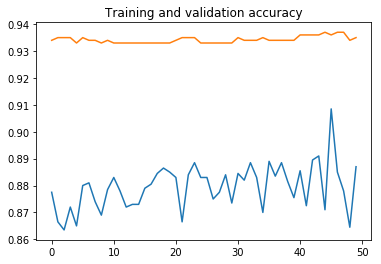

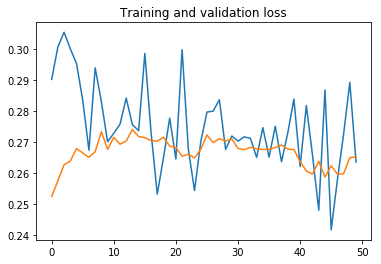

In [24]:
#分别用训练集和测试集的正确率、损失率作图，显示不过拟合且验证正确率进一步提高。
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

acc = history.history['acc']
val_acc =history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [25]:
#保存模型
model.save('E:\\python projects\\use_inception_v3_dogs_and_cats_classifer.h5')

C:\1.jpg


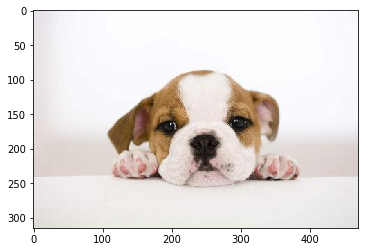

This is a dog.


In [78]:
#使用训练好的模型对图片进行预测，并输出预测结果。效果很好。
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import random

validation_cat_fnames = os.listdir(validation_cats_dir)
validation_dog_fnames = os.listdir(validation_dogs_dir)
cat_pics = [os.path.join(validation_cats_dir, f) for f in validation_cat_fnames]
dog_pics = [os.path.join(validation_dogs_dir, f) for f in validation_dog_fnames]
#img_chosen = random.choice(cat_pics + dog_pics)
img_chosen = 'C:\\1.jpg'
img = load_img(img_chosen, target_size=(150, 150))
y = img_to_array(img)
y = y.reshape((1,) + y.shape)
y /= 255

predict_class = model.predict(y)

print(img_chosen)
img = mpimg.imread(img_chosen)
plt.imshow(img)
plt.show()
if predict_class >= 0.7:
    print('This is a dog.')
else:
    print('This is a cat.')

In [ ]:
#终止内核，释放内存。
import os, signal
#os.kill(os.getpid(), signal.SIGKILL) 